In [5]:
from pyPolCal.csv_tools import read_csv_physical_model_all_bins, write_fits_info_to_csv,model_data
import numpy as np
import pandas as pd
from pyMuellerMat.physical_models.charis_physical_models import HWP_retardance,IMR_retardance
from pyPolCal.constants import wavelength_bins
from pyPolCal.utils import *
from pyPolCal.fitting import *

In [4]:
cubedir = '/home/thomasmc/cubes/internal-cal-cubes/pdi-calib-2025-06-05/data/raw'
rawdir = '/home/shared/exoserver/CHARIS-cals/internal-cal'

# write to csv
for bin in range(22):
    csvpath = f'/home/thomasmc/cubes/csvs/bin{bin}.csv'
    write_fits_info_to_csv(cubedir, rawdir, csvpath, bin, hwp_order=None, hwp_angles_to_delete=None)

CSV file written to /home/thomasmc/cubes/csvs/bin0.csv
CSV file written to /home/thomasmc/cubes/csvs/bin1.csv
CSV file written to /home/thomasmc/cubes/csvs/bin2.csv
CSV file written to /home/thomasmc/cubes/csvs/bin3.csv
CSV file written to /home/thomasmc/cubes/csvs/bin4.csv
CSV file written to /home/thomasmc/cubes/csvs/bin5.csv
CSV file written to /home/thomasmc/cubes/csvs/bin6.csv
CSV file written to /home/thomasmc/cubes/csvs/bin7.csv
CSV file written to /home/thomasmc/cubes/csvs/bin8.csv
CSV file written to /home/thomasmc/cubes/csvs/bin9.csv
CSV file written to /home/thomasmc/cubes/csvs/bin10.csv
CSV file written to /home/thomasmc/cubes/csvs/bin11.csv
CSV file written to /home/thomasmc/cubes/csvs/bin12.csv
CSV file written to /home/thomasmc/cubes/csvs/bin13.csv
CSV file written to /home/thomasmc/cubes/csvs/bin14.csv
CSV file written to /home/thomasmc/cubes/csvs/bin15.csv
CSV file written to /home/thomasmc/cubes/csvs/bin16.csv
CSV file written to /home/thomasmc/cubes/csvs/bin17.csv
CS

In [21]:
import os
# replace corrupted RET-ANG1 values with 0

csvdir = '/home/thomasmc/cubes/csvs'
for bin in range(22):
    csvpath = os.path.join(csvdir, f'bin{bin}.csv')
    df = pd.read_csv(csvpath)
    if 'RET-ANG1' in df.columns:
        df['RET-ANG1'] = 0
        df.to_csv(csvpath, index=False)

In [ ]:
csvdir = '/home/thomasmc/cubes/csvs'


In [8]:
# set up model
jsondir ='/home/thomasmc/cubes/jsons' 
df = model_data(jsondir)
imr_phis = df['image_rotator_phi'].to_numpy()
wol_eta_list = np.array([i for i in df['wollaston_eta'].values for _ in range(72)])
lp_eps_list = np.array([i for i in df['lp_epsilon'].values for _ in range(72)])
imr_phi_list = np.array([i for i in imr_phis for _ in range(72)])
bin_list = np.array([i for i in wavelength_bins for _ in range(72)])
interleaved_values_internal, interleaved_stds_internal, config_list_internal = read_csv_physical_model_all_bins('/home/thomasmc/cubes/csvs')

# process interleaved values into normalized single differences
interleaved_values_internal = interleaved_values_internal[::2]/interleaved_values_internal[1::2]
interleaved_values_internal

array([ 0.23779736,  0.23394407,  0.24077129, ..., -0.42619405,
       -0.42591739, -0.4259192 ])

In [9]:
modeled_internal = np.array([])
for dd in range(len(config_list_internal)):

    # get model ready
    imr_phi = imr_phi_list[dd]
    offset_imr = -0.13959
    offset_hwp = 0
    offset_cal = -0.11835
    lp_eps = lp_eps_list[dd]
    wavelength_bin = bin_list[dd]
    hwp_phi = HWP_retardance(wavelength_bin, 1.63398,1.27711)[0]
    #imr_phi = IMR_retardance(wavelength_bin ,259.11814)[0]
    wol_eta = wol_eta_list[dd]

    # define system dictionary
    system_dict = {
            "components" : {
                "wollaston" : {
                "type" : "wollaston_prism_function",
                "properties" : {"beam": 'o','eta':wol_eta}, 
                "tag": "internal",
                },
                "image_rotator" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": imr_phi, "theta": 0, "delta_theta": offset_imr},
                    "tag": "internal",
                },
                "hwp" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": hwp_phi, "theta": 0, "delta_theta": offset_hwp},
                    "tag": "internal",
                },
                "lp_rot": {
                    "type": "rotator_function",
                    "properties": {"theta": offset_cal},
                    "tag": "internal",
                },
                "lp" : {  # calibration polarizer for internal calibration source
                    "type": "diattenuator_retarder_function",
                    "properties": {"epsilon": lp_eps},
                    "tag": "internal",
                }},
        }
    
    # define p0 dict (it doesnt do anything its just necessary for model function to work)

    p0_dict = {
    "lp" : 
        {"epsilon":lp_eps}
}

    # generate system mueller matrix    
    system_mm = generate_system_mueller_matrix(system_dict)
    p, pkeys = parse_configuration(p0_dict)
    
    # generate model
    configlist = [config_list_internal[dd]]
    modeled_dd = model(p, pkeys, system_mm, configlist)
    modeled_internal = np.concatenate((modeled_internal, modeled_dd))

# process into norm single diffs
modeled_internal = (modeled_internal[1::2]-modeled_internal[::2])/(modeled_internal[::2]+modeled_internal[1::2])

print(modeled_internal)

Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelengt

In [10]:
# calculate s res

# generate s
s_res_by_wavelength = []
for bin in range(22):
    # mask per bin
    bin_mask = []
    for dict in config_list_internal:
        if dict['hwp']['wavelength'] == wavelength_bins[bin]:
            bin_mask.append(True)
        else:
            bin_mask.append(False)

    # apply mask
    double_diffs_bin = interleaved_values_internal[bin_mask]
    modeled_double_differences_bin = modeled_internal[bin_mask]
    # calculate s_res as in appendix E of SPHERE cal paper
    residuals = (double_diffs_bin*100-modeled_double_differences_bin*100)
    s_res = np.sqrt(np.sum(residuals**2)/(len(interleaved_values_internal[bin_mask])))
    s_res_by_wavelength.append(s_res)

Text(0, 0.5, 's_rel (%)')

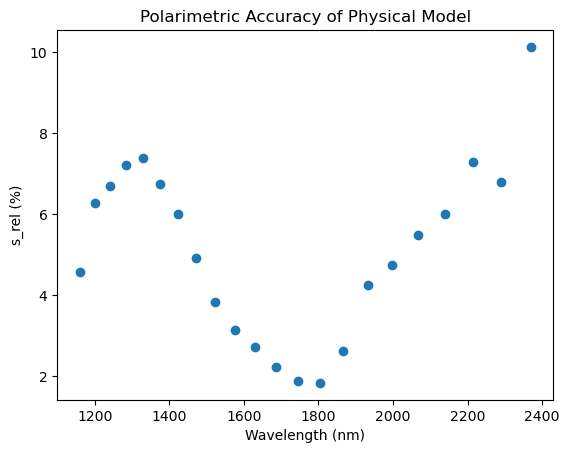

In [11]:
import matplotlib.pyplot as plt
plt.scatter(wavelength_bins, s_res_by_wavelength)
plt.title('Polarimetric Accuracy of Physical Model')
plt.xlabel('Wavelength (nm)')
plt.ylabel ('s_rel (%)')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.8551e-02                                    7.98e-01    
       1              2         1.4426e-02      5.41e-02       5.39e-02       8.16e-02    
       2              3         1.3698e-02      7.28e-04       1.25e-02       1.35e-03    
       3              4         1.3698e-02      2.06e-07       1.43e-04       8.53e-07    
       4              5         1.3698e-02      1.68e-13       2.51e-06       5.71e-09    
`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 6.8551e-02, final cost 1.3698e-02, first-order optimality 5.71e-09.
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-3.474e-02 -3.088e-02 ... -4.108e-03 -4.409e-03]
           x: [-1.601e+00  4.512e+00  1.000e+00  1.000e+00]
        cost: 0.013698023916407348
         jac: [[-1.852e-03 -9.739e-01  2.031e-01  2.031

/home/thomasmc/pyPolCal/pyPolCal/fitting.py:160: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(np.diag(cov))


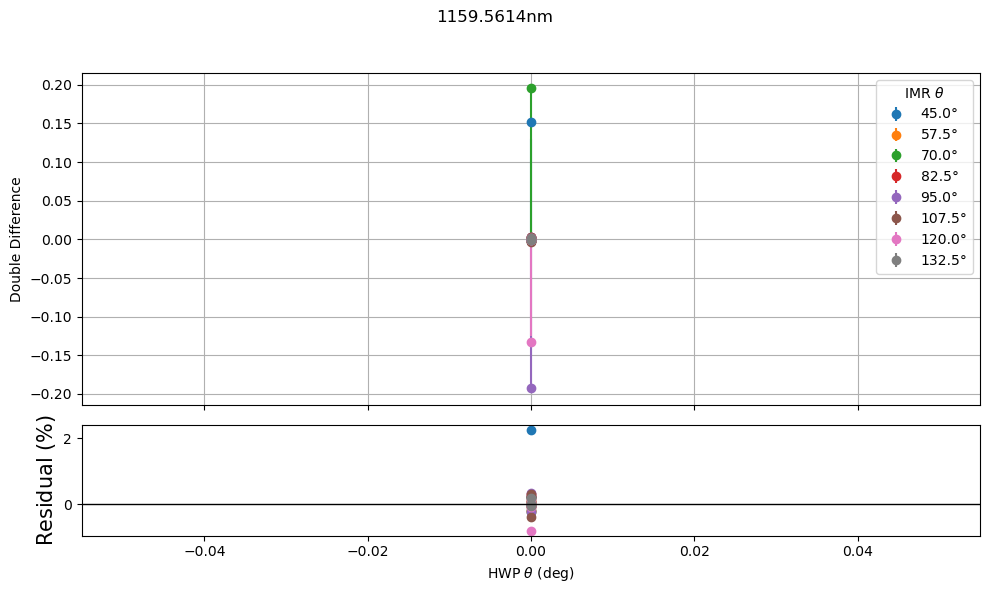

Updated Mueller Matrix:
[[ 5.97724478e-01  5.97719377e-01 -2.46927564e-03 -6.93461456e-06]
 [-5.97724478e-01 -5.97719377e-01  2.46927564e-03  6.93461456e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
144 72
Residuals range: -0.008096589008196209 0.022521205006277967
Error: [0.08952566 0.0036767         nan        nan]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.3770e-02                                    4.88e-01    
       1              2         2.1361e-03      3.16e-02       2.84e-01       4.94e-02    
       2              3         1.7462e-03      3.90e-04       1.63e-02       4.00e-02    
       3              4         1.7364e-03      9.85e-06       1.09e-03       1.54e-05    
       4              5         1.7364e-03      5.58e-12       1.58e-05       4.74e-10    
`gtol` termination condition is satisfied

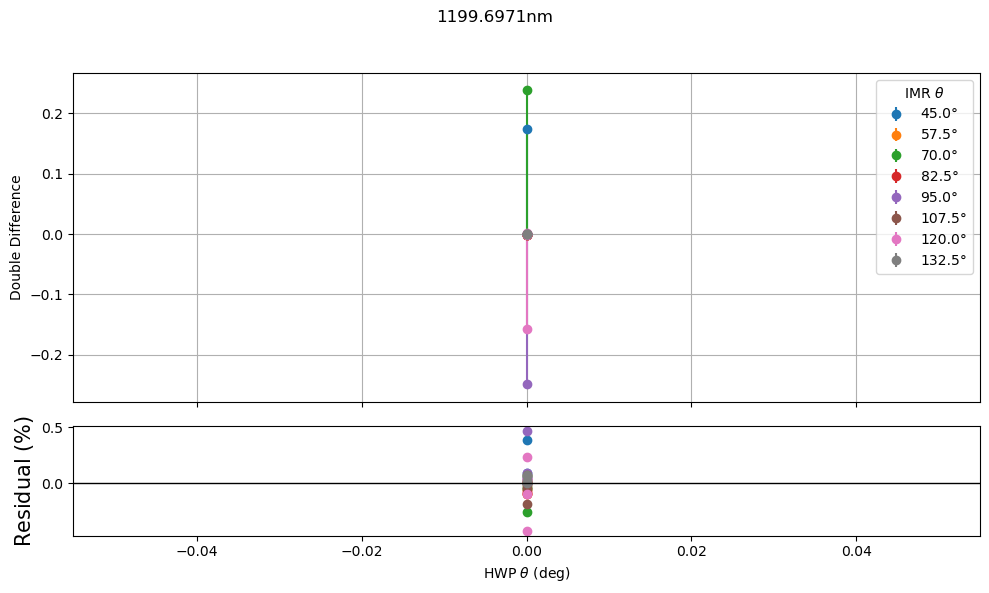

Updated Mueller Matrix:
[[ 0.76334977  0.76319696 -0.00332962 -0.01489929]
 [-0.76327298 -0.76312032  0.00332936  0.01490413]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
144 72
Residuals range: -0.004263628051278556 0.0046339978332547715
Error: [2.50400078e-02 1.60867829e-03 4.29123587e+04 4.28998703e+04]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.4768e-02                                    1.11e+00    
       1              2         4.4687e-02      1.01e-02       1.87e-02       2.98e-01    
       2              3         1.1521e-02      3.32e-02       1.86e-01       2.69e-02    
       3              4         1.0839e-02      6.82e-04       1.17e-02       9.80e-04    
       4              5         1.0837e-02      2.45e-06       2.21e-04       8.15e-06    
       5              6         1.0837e-02      2.15e-09       2.84e-06       1.99e-08  

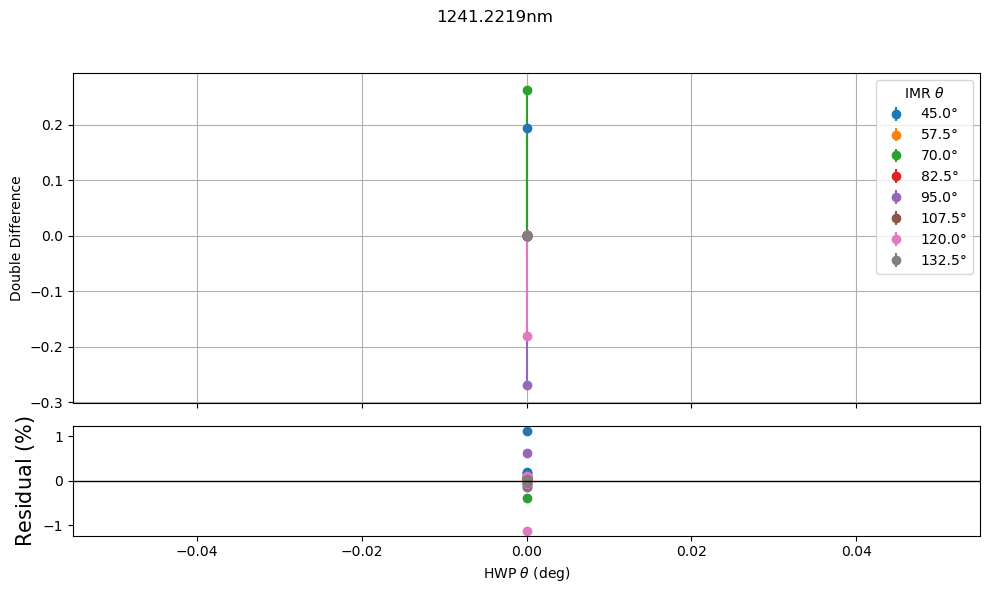

Updated Mueller Matrix:
[[ 8.33066508e-01  8.33059399e-01 -3.44154992e-03 -5.55653387e-09]
 [-8.33066508e-01 -8.33059399e-01  3.44154992e-03  5.55653387e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
144 72
Residuals range: -0.01122830651666018 0.01127439576787112
Error: [5.77544604e-02 4.83224937e-03 2.33852903e+05 2.33852901e+05]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6851e-01                                    3.48e+00    
       1              2         3.6026e-02      1.32e-01       1.87e-01       1.09e-01    
       2              3         1.4437e-02      2.16e-02       6.54e-02       1.79e-02    
       3              4         1.3914e-02      5.23e-04       9.46e-03       7.92e-04    
       4              5         1.3888e-02      2.61e-05       1.39e-03       1.02e-05    
       5              6    

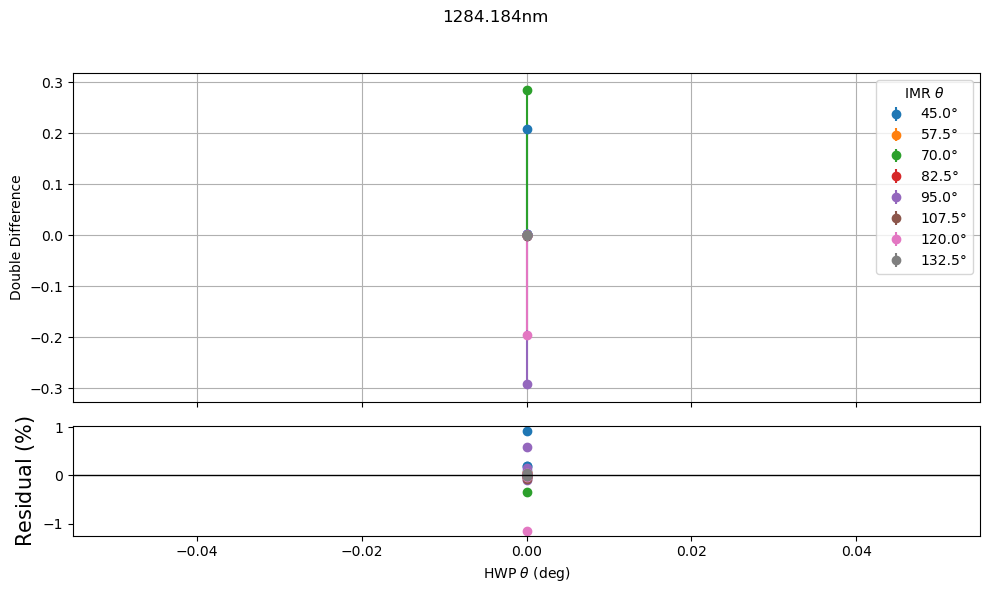

Updated Mueller Matrix:
[[ 9.02065593e-01  9.02057895e-01 -3.72659767e-03 -4.42901066e-09]
 [-9.02065593e-01 -9.02057895e-01  3.72659767e-03  4.42901066e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
144 72
Residuals range: -0.011464845273212704 0.009155537354478022
Error: [5.88461033e-02 7.40204972e-03 7.21191211e+04 7.21191209e+04]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7275e-01                                    3.86e+00    
       1              2         7.4769e-02      9.80e-02       1.85e-01       4.74e-02    
       2              3         3.7240e-02      3.75e-02       1.04e-01       1.12e-02    
       3              4         2.6324e-02      1.09e-02       3.55e-02       2.02e-03    
       4              5         2.3656e-02      2.67e-03       9.83e-03       2.64e-04    
       5              6  

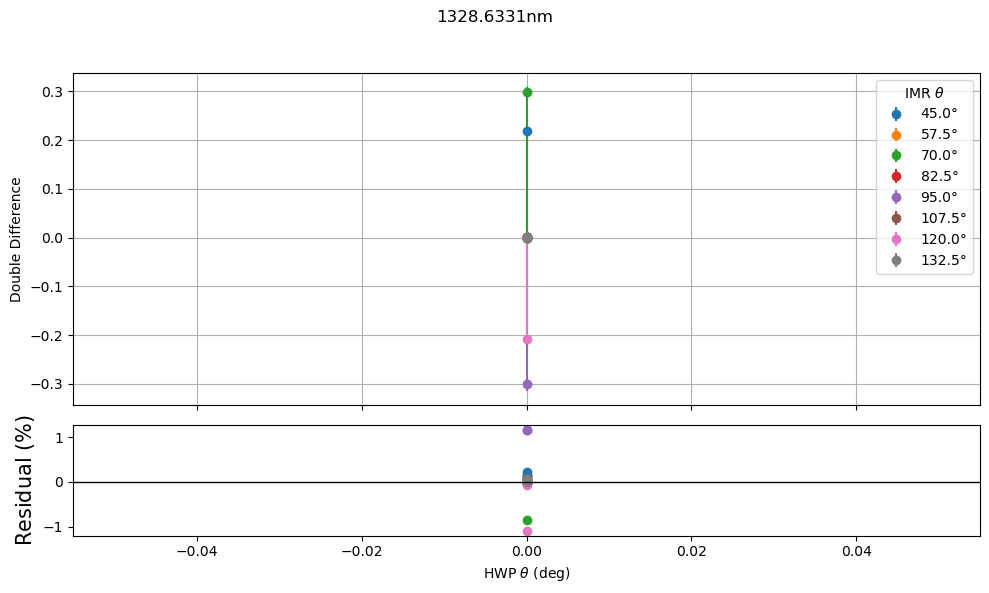

Updated Mueller Matrix:
[[ 9.54921660e-01  9.54913512e-01 -3.94480581e-03 -2.93032045e-06]
 [-9.54921660e-01 -9.54913512e-01  3.94480581e-03  2.93032045e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
144 72
Residuals range: -0.010906774916003392 0.011576694656433073
Error: [7.12175245e-02 1.48421190e-02 1.04186487e+05 1.04186487e+05]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.9424e-01                                    4.77e+00    
       1              2         1.1502e-01      1.79e-01       2.01e-01       9.86e-02    
       2              3         5.2883e-02      6.21e-02       9.72e-02       2.44e-02    
       3              4         3.4867e-02      1.80e-02       3.70e-02       5.26e-03    
       4              5         2.9940e-02      4.93e-03       1.27e-02       7.47e-04    
       5              6  

/home/thomasmc/pyPolCal/pyPolCal/fitting.py:160: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(np.diag(cov))


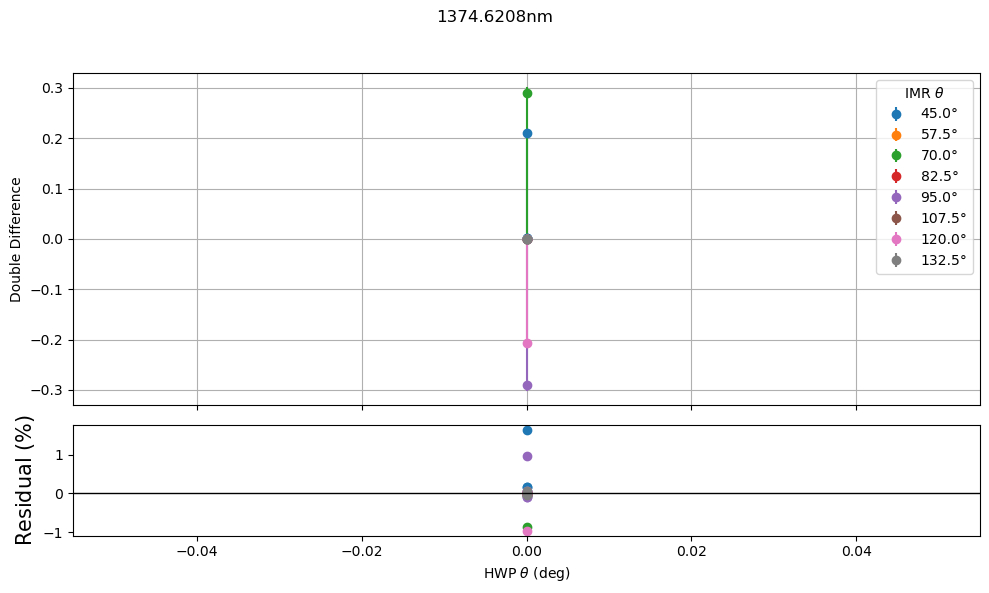

Updated Mueller Matrix:
[[ 9.26334141e-01  9.26326241e-01 -3.82572475e-03  3.51699791e-06]
 [-9.26334141e-01 -9.26326241e-01  3.82572475e-03 -3.51699792e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
144 72
Residuals range: -0.00959775141829941 0.01630841016296397
Error: [7.76400929e-02 1.22872351e-02 2.06394394e+05 2.06394395e+05]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8932e-01                                    3.64e+00    
       1              2         8.0980e-02      2.08e-01       2.37e-01       1.52e-01    
       2              3         2.8793e-02      5.22e-02       6.76e-02       3.68e-02    
       3              4         2.2704e-02      6.09e-03       2.15e-02       7.00e-03    
       4              5         2.2220e-02      4.84e-04       6.19e-03       1.38e-03    
       5              6    

/home/thomasmc/pyPolCal/pyPolCal/fitting.py:160: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(np.diag(cov))


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2200e-02                                    4.10e-09    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 2.2200e-02, final cost 2.2200e-02, first-order optimality 4.10e-09.
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-3.863e-02 -3.865e-02 ... -1.470e-02 -1.471e-02]
           x: [-1.366e+00  2.337e+00  1.000e+00  1.000e+00]
        cost: 0.022200006968563828
         jac: [[ 7.483e-03  7.226e-01  6.863e-01  6.863e-01]
               [ 7.483e-03  7.226e-01  6.863e-01  6.863e-01]
               ...
               [-1.008e-02  7.134e-01  6.946e-01  6.946e-01]
               [-1.008e-02  7.134e-01  6.946e-01  6.946e-01]]
        grad: [ 1.128e-09  5.504e-09 -5.056e-01 -5.056e-01]
  optimality: 4.099927338097542e-09
 active_mask: [0 0 1 1]
        nfev: 1
        njev: 1


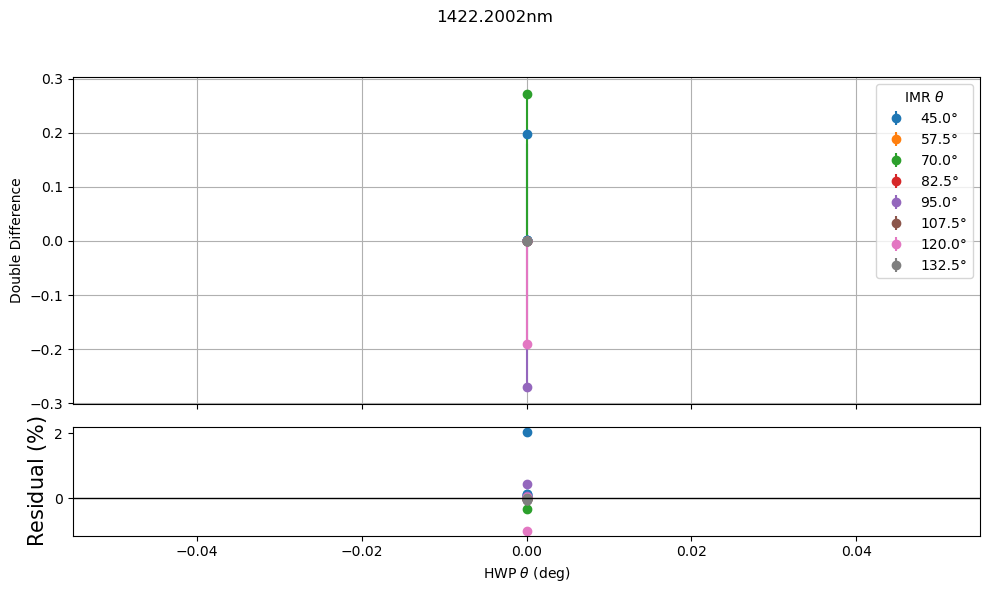

Updated Mueller Matrix:
[[ 8.47283424e-01  8.47276200e-01 -3.49889714e-03  4.89484600e-06]
 [-8.47283424e-01 -8.47276200e-01  3.49889714e-03 -4.89484600e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
144 72
Residuals range: -0.009880673714593557 0.02039068415166531
Error: [7.28385230e-02 7.26174134e-03 1.77206231e+05 1.77206232e+05]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8172e-01                                    1.71e+00    
       1              2         3.0999e-02      1.51e-01       2.94e-01       1.34e-01    
       2              3         1.1868e-02      1.91e-02       3.32e-02       2.33e-02    
       3              4         9.1756e-03      2.69e-03       1.35e-02       1.76e-03    
       4              5         8.9474e-03      2.28e-04       1.19e-03       1.56e-05    
       5              6   

/home/thomasmc/pyPolCal/pyPolCal/fitting.py:160: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(np.diag(cov))


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.9387e-03                                    7.81e-09    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 8.9387e-03, final cost 8.9387e-03, first-order optimality 7.81e-09.
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-2.879e-02 -2.949e-02 ... -4.291e-03 -4.734e-03]
           x: [-1.298e+00  2.093e+00  1.000e+00  1.000e+00]
        cost: 0.008938660342112336
         jac: [[ 7.040e-03  8.669e-01  4.922e-01  4.922e-01]
               [ 7.040e-03  8.669e-01  4.922e-01  4.922e-01]
               ...
               [-1.112e-02  8.599e-01  5.015e-01  5.015e-01]
               [-1.112e-02  8.599e-01  5.015e-01  5.015e-01]]
        grad: [ 2.110e-09 -1.400e-09 -2.853e-01 -2.853e-01]
  optimality: 7.81321253685174e-09
 active_mask: [0 0 1 1]
        nfev: 1
        njev: 1


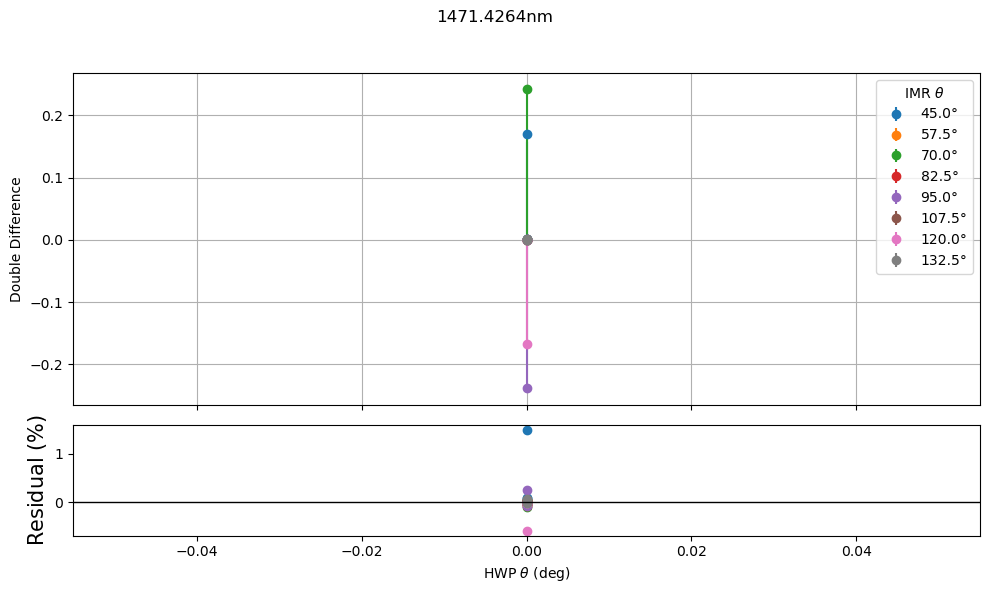

Updated Mueller Matrix:
[[ 7.50748132e-01  7.50741733e-01 -3.09989767e-03  5.91006094e-06]
 [-7.50748132e-01 -7.50741733e-01  3.09989767e-03 -5.91006094e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
144 72
Residuals range: -0.0058620987582049255 0.014899794374553882
Error: [5.10772407e-02 3.49063297e-03 2.54376270e+05 2.54376270e+05]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0439e-01                                    4.32e-01    
       1              2         3.6834e-02      6.76e-02       5.96e-02       2.29e-01    
       2              3         9.1271e-03      2.77e-02       3.95e-01       1.71e-02    
       3              4         6.6181e-03      2.51e-03       1.44e-02       6.18e-04    
       4              5         6.0002e-03      6.18e-04       2.46e-03       1.13e-04    
       5              6 

/home/thomasmc/pyPolCal/pyPolCal/fitting.py:160: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(np.diag(cov))


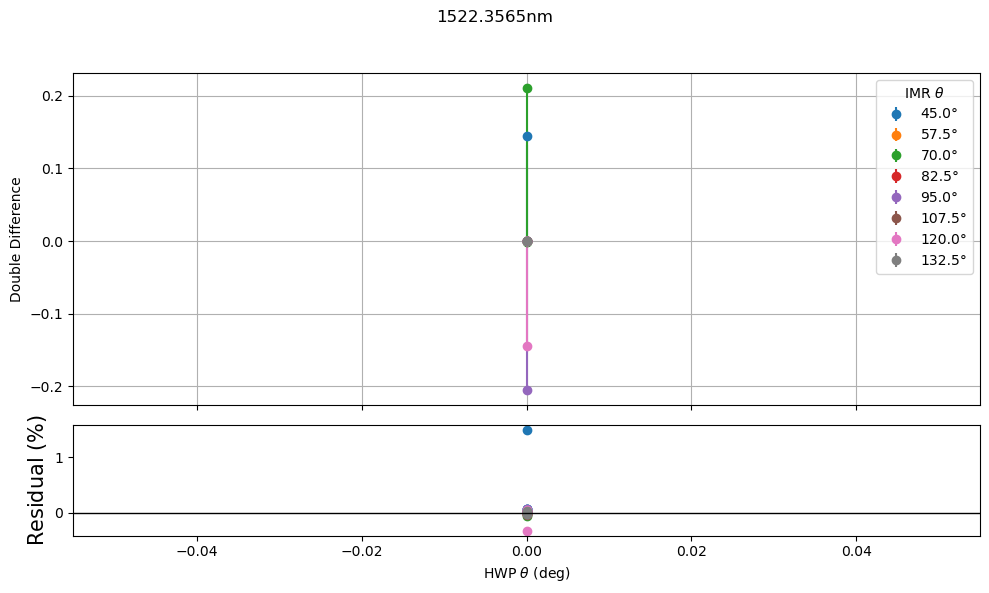

Updated Mueller Matrix:
[[ 6.42334154e-01  6.42328679e-01 -2.65189274e-03  6.56007057e-06]
 [-6.42334153e-01 -6.42328679e-01  2.65189274e-03 -6.56007058e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
144 72
Residuals range: -0.0032434522694119172 0.014883339690274278
Error: [0.04718319 0.00243917        nan        nan]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1727e-02                                    2.07e-01    
       1              2         3.6031e-03      1.81e-02       4.40e-01       1.66e-02    
       2              3         3.3583e-03      2.45e-04       3.56e-02       3.92e-04    
       3              4         3.3581e-03      1.22e-07       1.20e-04       6.59e-07    
       4              5         3.3581e-03      1.66e-13       1.78e-06       4.37e-09    
`gtol` termination condition is satisfie

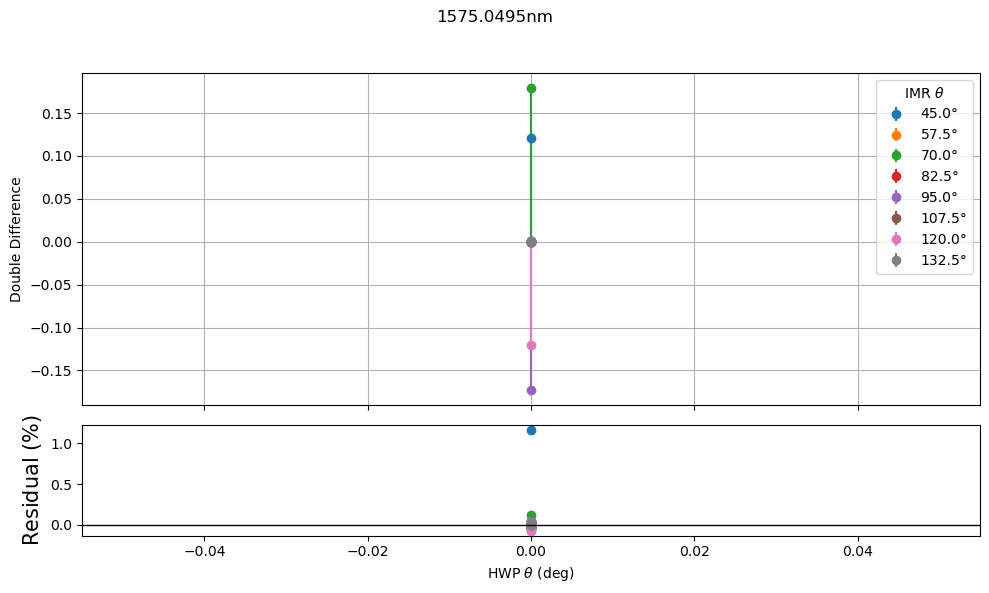

Updated Mueller Matrix:
[[ 5.43072339e-01  5.43067704e-01 -2.24352917e-03  7.19581652e-09]
 [-5.43072339e-01 -5.43067704e-01  2.24352917e-03 -7.19581652e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
144 72
Residuals range: -0.000704469291105389 0.011641981707236432
Error: [4.16072947e-02 1.81834869e-03 4.24648692e+04 4.24648689e+04]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5886e-03                                    3.85e-01    
       1              2         1.3058e-03      7.28e-03       4.07e-01       5.52e-03    
       2              3         1.2526e-03      5.33e-05       2.14e-02       6.19e-05    
       3              4         1.2522e-03      3.23e-07       2.37e-04       3.54e-07    
       4              5         1.2522e-03      1.49e-09       1.87e-05       1.18e-08    
       5              6  

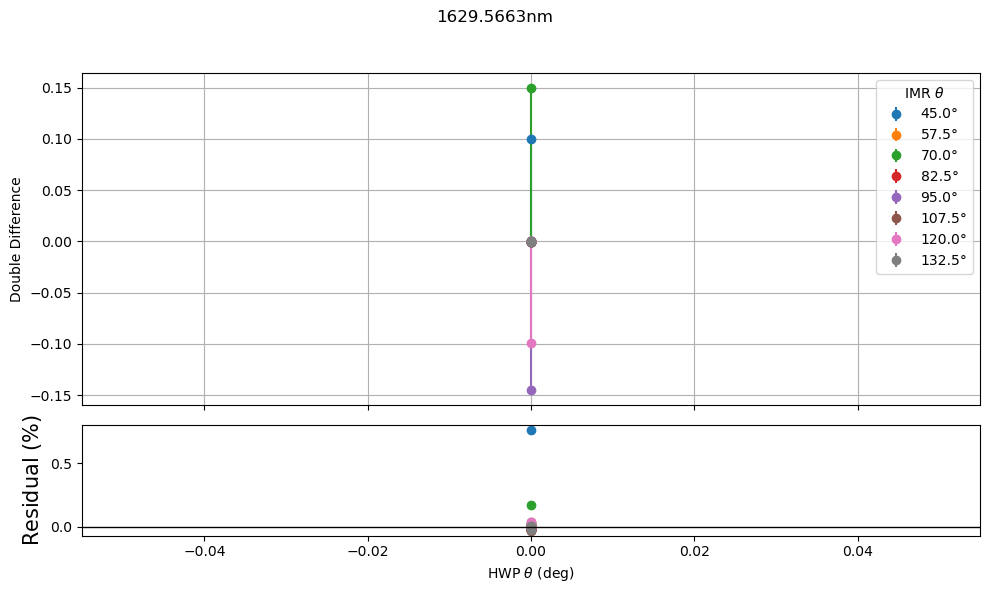

Updated Mueller Matrix:
[[ 0.45505742  0.4543314   0.00438167  0.02530014]
 [-0.45468343 -0.45395786 -0.00438751 -0.02531751]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
144 72
Residuals range: -0.00030173849368560847 0.007587129480496321
Error: [2.98140036e-02 1.18264872e-03 2.18070288e+04 2.17920545e+04]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.1297e-02                                    1.56e+00    
       1              2         2.7745e-03      2.85e-02       4.22e-01       2.83e-02    
       2              3         6.6178e-04      2.11e-03       3.14e-02       2.92e-03    
       3              4         6.2303e-04      3.88e-05       2.79e-03       5.38e-05    
       4              5         6.2286e-04      1.70e-07       2.27e-04       1.81e-07    
       5              6         6.2286e-04      9.36e-11       8.09e-06       3.47e-09 

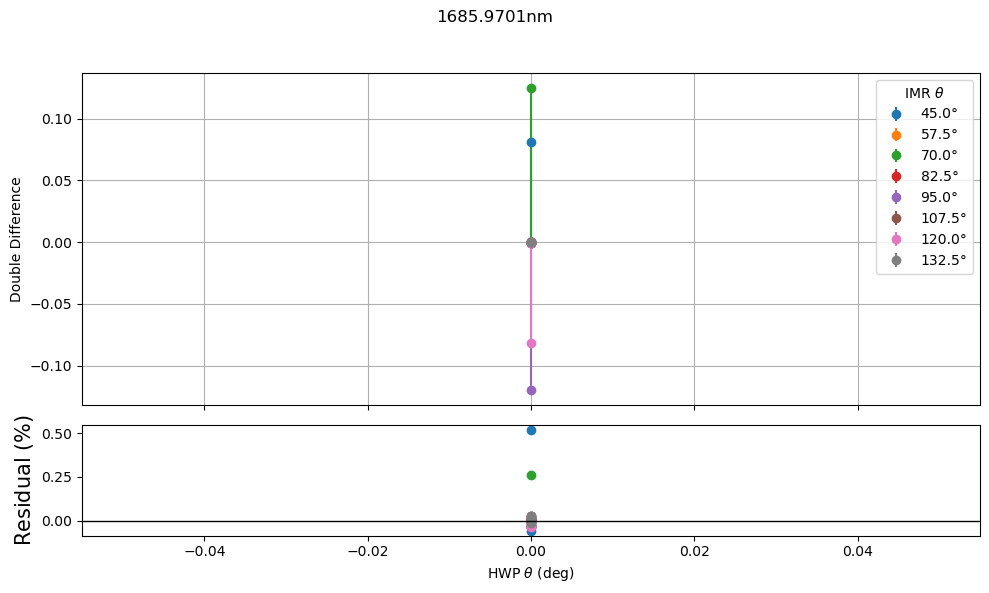

Updated Mueller Matrix:
[[ 0.37750408  0.37577193  0.00698432  0.03538366]
 [-0.37662222 -0.37489164 -0.00700006 -0.03543384]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
144 72
Residuals range: -0.0005837285146693507 0.005193240528284293
Error: [2.66061356e-02 9.37270032e-04 4.01647762e+04 4.01078119e+04]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.7970e-02                                    3.30e+00    
       1              2         1.5763e-02      7.22e-02       3.58e-01       5.19e-02    
       2              3         2.4604e-03      1.33e-02       1.02e-01       1.17e-02    
       3              4         6.5202e-04      1.81e-03       2.57e-02       2.05e-03    
       4              5         5.4227e-04      1.10e-04       6.08e-03       1.56e-04    
       5              6         5.4105e-04      1.22e-06       4.10e-04       1.51e-06  

/home/thomasmc/pyPolCal/pyPolCal/fitting.py:160: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(np.diag(cov))


     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-8.370e-03 -8.119e-03 ...  5.560e-03  5.347e-03]
           x: [-1.112e+00  1.204e+00  9.982e-01  9.965e-01]
        cost: 0.0005410520759319985
         jac: [[ 2.409e-03  9.248e-01 -3.602e-01 -3.608e-01]
               [ 2.409e-03  9.248e-01 -3.602e-01 -3.608e-01]
               ...
               [-1.032e-02  9.263e-01 -3.527e-01 -3.533e-01]
               [-1.032e-02  9.263e-01 -3.527e-01 -3.533e-01]]
        grad: [-4.313e-10  4.528e-10 -1.327e-09 -2.679e-10]
  optimality: 2.6361901184177655e-09
 active_mask: [0 0 0 0]
        nfev: 8
        njev: 8
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.4105e-04                                    2.64e-09    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 5.4105e-04, final cost 5.4105e-04, first-order optimality 2.64e-09.
 

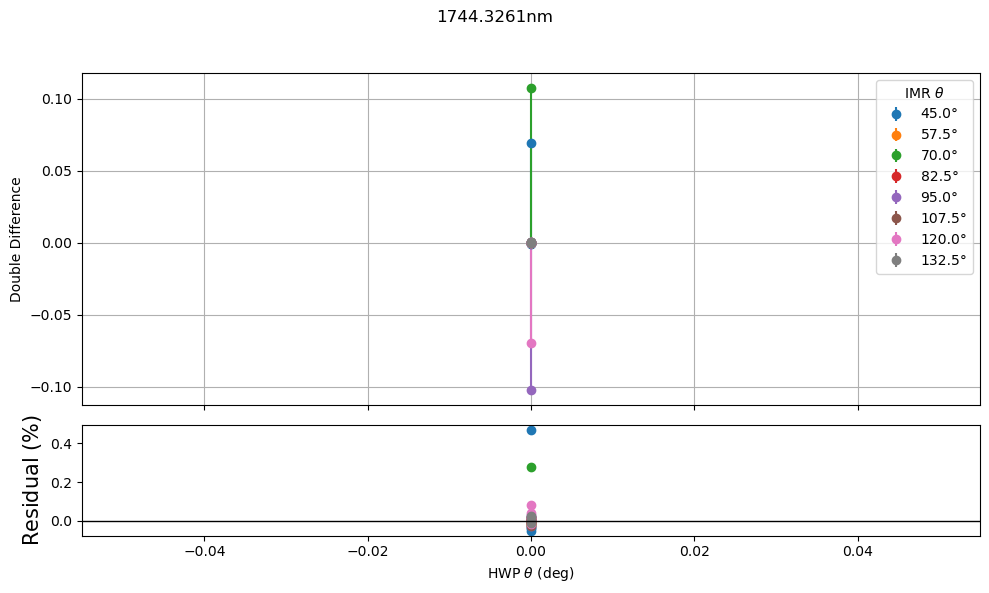

Updated Mueller Matrix:
[[ 0.32397032  0.32162351  0.00754401  0.0381054 ]
 [-0.32278528 -0.32044055 -0.00756447 -0.03817228]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
144 72
Residuals range: -0.0005003991480748846 0.004691031640630922
Error: [0.02682295 0.00094948        nan        nan]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2230e-01                                    4.53e+00    
       1              2         2.7319e-02      9.50e-02       1.08e-01       5.57e-02    
       2              3         6.9303e-03      2.04e-02       1.55e-01       1.32e-02    
       3              4         1.7784e-03      5.15e-03       4.65e-02       3.28e-03    
       4              5         5.3596e-04      1.24e-03       2.00e-02       8.17e-04    
       5              6         2.4898e-04      2.87e-04       9.55e-03       2.03e-04    
       6     

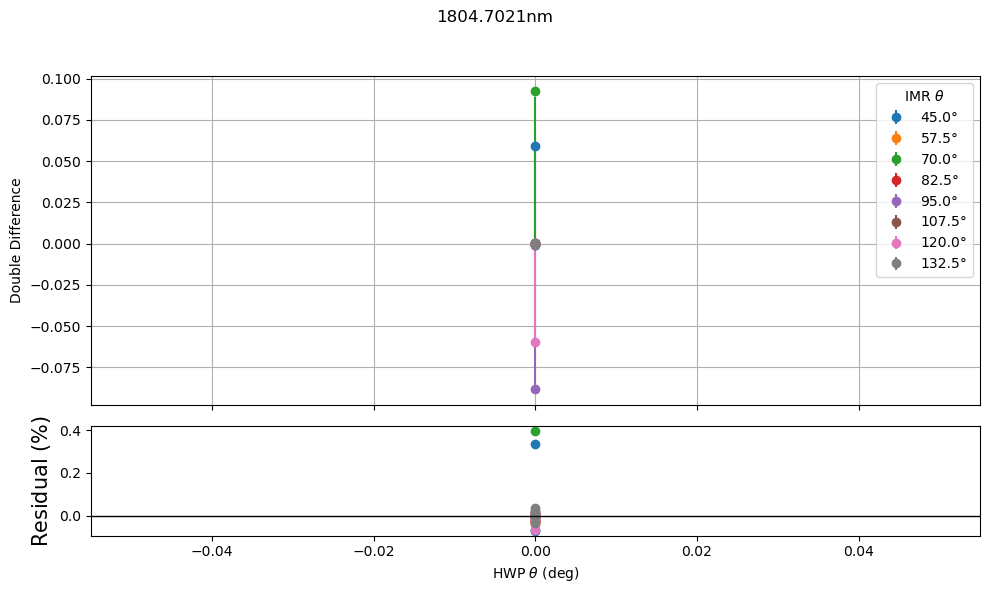

Updated Mueller Matrix:
[[ 0.27813774  0.27545984  0.00746385  0.03767955]
 [-0.27678132 -0.27410544 -0.00748563 -0.03775045]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
144 72
Residuals range: -0.0007041861782147695 0.003942205986414107
Error: [1.78853623e-02 5.98161954e-04 9.97253448e+03 9.95381708e+03]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1496e-01                                    6.65e+00    
       1              2         5.6909e-02      1.58e-01       1.30e-01       1.67e-01    
       2              3         2.4670e-02      3.22e-02       8.71e-02       1.42e-02    
       3              4         1.4349e-02      1.03e-02       6.81e-02       2.43e-03    
       4              5         1.2109e-02      2.24e-03       9.03e-03       1.47e-04    
       5              6         1.1962e-02      1.47e-04       3.72e-04       6.67e-06  

/home/thomasmc/pyPolCal/pyPolCal/fitting.py:160: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(np.diag(cov))


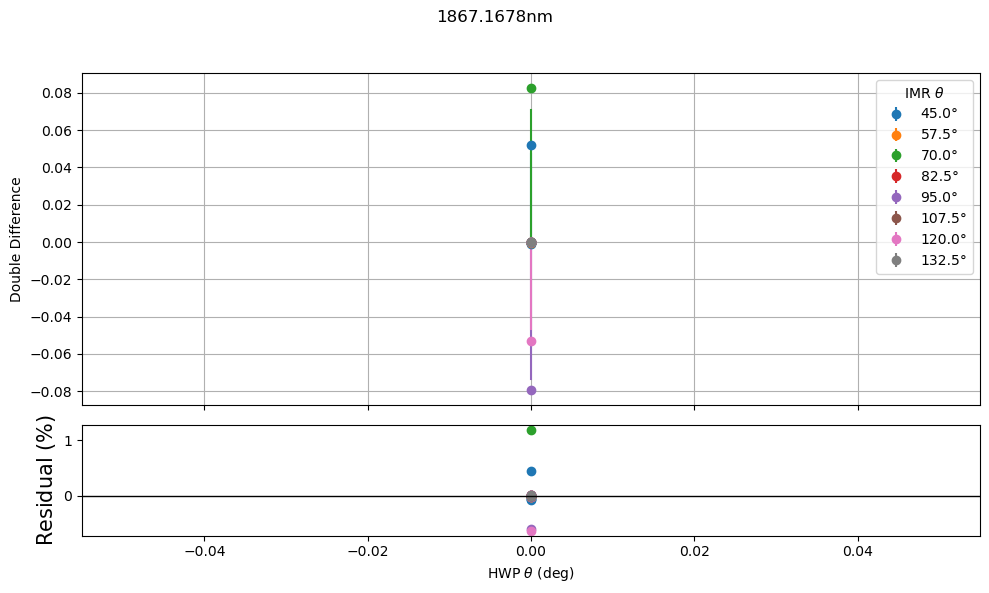

Updated Mueller Matrix:
[[ 0.24101293  0.22607231  0.01765288  0.080478  ]
 [-0.2335309  -0.21863612 -0.01786803 -0.08127651]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
144 72
Residuals range: -0.006375012142425314 0.011868894275090594
Error: [0.1806385  0.00565261        nan        nan]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.7461e-01                                    9.33e+00    
       1              2         1.0990e-01      2.65e-01       2.42e-01       3.51e-01    
       2              3         6.5624e-02      4.43e-02       1.21e-01       1.41e-02    
       3              4         5.2803e-02      1.28e-02       6.28e-02       1.04e-03    
       4              5         5.1747e-02      1.06e-03       3.15e-03       6.35e-05    
       5              6         5.1747e-02      4.65e-08       4.37e-04       6.13e-08    
       6      

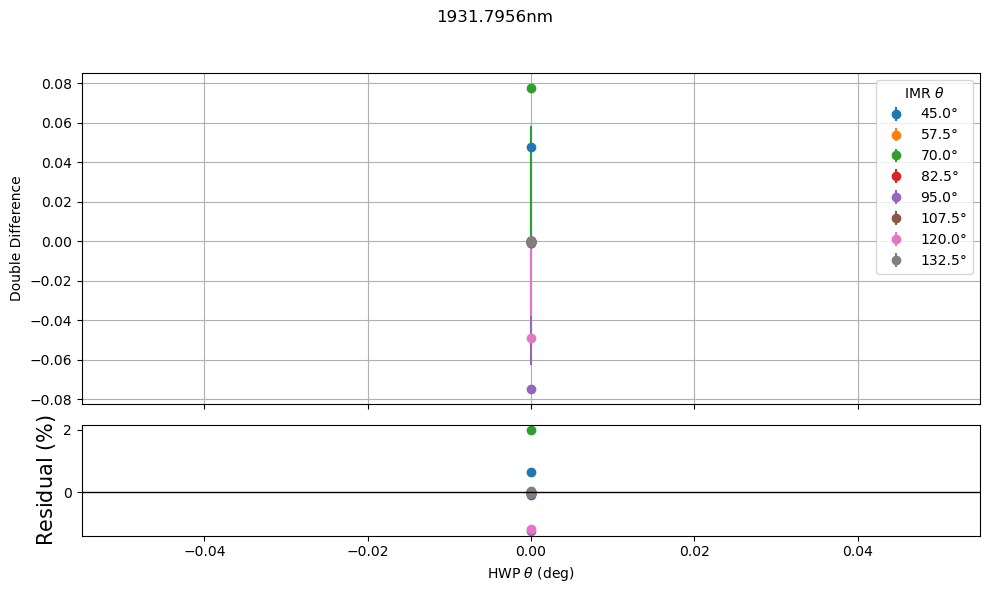

Updated Mueller Matrix:
[[ 0.2186808   0.18910136  0.02375398  0.10391529]
 [-0.20356662 -0.17413465 -0.02429634 -0.10595049]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
144 72
Residuals range: -0.012337321588407682 0.019718674223744057
Error: [4.57339428e-01 1.39598557e-02 3.84888101e+05 3.77725516e+05]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.1146e-01                                    1.01e+01    
       1              2         1.2157e-01      2.90e-01       2.96e-01       4.11e-01    
       2              3         7.8402e-02      4.32e-02       3.11e-01       1.24e-02    
       3              4         6.6636e-02      1.18e-02       2.03e-02       9.70e-04    
       4              5         6.5988e-02      6.48e-04       7.09e-03       5.12e-05    
       5              6         6.5988e-02      1.99e-08       4.97e-04       2.95e-08   

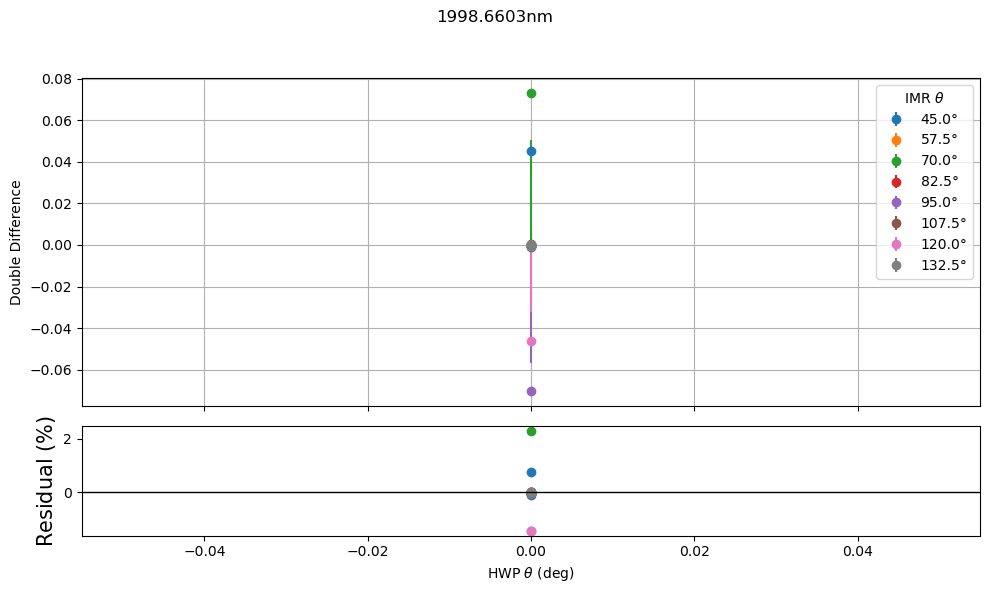

Updated Mueller Matrix:
[[ 0.20071688  0.16718519  0.02422693  0.10445602]
 [-0.18388464 -0.15051199 -0.02482751 -0.10668491]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
144 72
Residuals range: -0.014329981638289704 0.02284490264012401
Error: [6.43973203e-01 1.65559920e-02 2.82687730e+05 2.76764021e+05]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.9125e-01                                    1.14e+01    
       1              2         1.4494e-01      3.46e-01       3.68e-01       5.12e-01    
       2              3         9.9494e-02      4.54e-02       5.93e-01       1.17e-02    
       3              4         8.7753e-02      1.17e-02       1.65e-01       1.83e-03    
       4              5         8.7359e-02      3.94e-04       1.96e-02       5.47e-05    
       5              6         8.7359e-02      2.64e-08       1.40e-03       5.97e-08    

/home/thomasmc/pyPolCal/pyPolCal/fitting.py:160: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(np.diag(cov))


     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-5.984e-02 -5.978e-02 ... -7.017e-02 -6.997e-02]
           x: [-2.731e+00  8.260e-01  9.772e-01  9.543e-01]
        cost: 0.08735907693307243
         jac: [[-7.338e-03  6.721e-01 -6.379e-01 -6.531e-01]
               [-7.338e-03  6.721e-01 -6.379e-01 -6.531e-01]
               ...
               [-1.104e-02  6.820e-01 -6.304e-01 -6.455e-01]
               [-1.104e-02  6.820e-01 -6.304e-01 -6.455e-01]]
        grad: [-1.952e-09 -1.056e+00 -2.420e-08 -9.465e-09]
  optimality: 1.508997269395904e-08
 active_mask: [0 1 0 0]
        nfev: 7
        njev: 7
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.7359e-02                                    1.10e-08    
       1              2         8.7359e-02      1.06e-10       2.13e-04       7.32e-08    
`ftol` termination condition is satisfied.
Function evaluatio

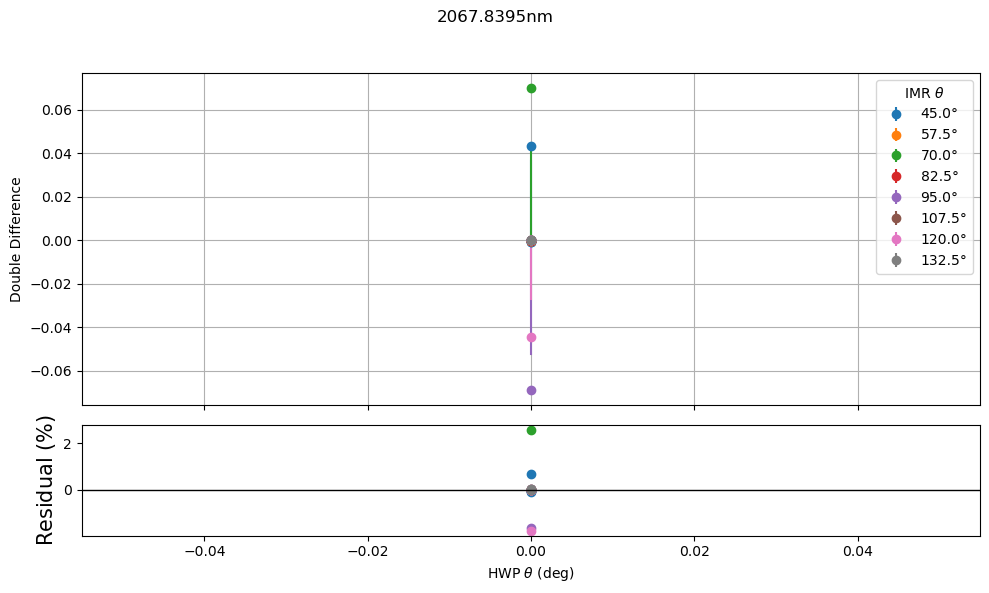

Updated Mueller Matrix:
[[ 0.19198667  0.15436852  0.02627345  0.10646376]
 [-0.1735017  -0.13606273 -0.02697348 -0.10893401]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
144 72
Residuals range: -0.017526717135301732 0.025604053262135468
Error: [0.78906557 0.01933033        nan        nan]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.4055e-01                                    1.21e+01    
       1              2         1.5862e-01      3.82e-01       4.03e-01       5.76e-01    
       2              3         1.1183e-01      4.68e-02       7.89e-01       1.14e-02    
       3              4         9.9841e-02      1.20e-02       4.04e-01       4.33e-03    
       4              5         9.9531e-02      3.10e-04       5.32e-02       1.31e-04    
       5              6         9.9531e-02      2.31e-07       7.75e-03       8.32e-07    
       6      

/home/thomasmc/pyPolCal/pyPolCal/fitting.py:160: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(np.diag(cov))


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.9531e-02                                    2.55e-08    
       1              4         9.9531e-02      1.08e-10       6.03e-04       1.02e-06    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 9.9531e-02, final cost 9.9531e-02, first-order optimality 1.02e-06.
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-6.006e-02 -6.009e-02 ... -7.809e-02 -7.809e-02]
           x: [-3.242e+00  8.058e-01  9.776e-01  9.538e-01]
        cost: 0.0995306007773938
         jac: [[-9.864e-03  6.563e-01 -6.445e-01 -6.606e-01]
               [-9.864e-03  6.563e-01 -6.445e-01 -6.606e-01]
               ...
               [-1.193e-02  6.646e-01 -6.403e-01 -6.562e-01]
               [-1.193e-02  6.646e-01 -6.403e-01 -6.562e-01]]
        grad: [-1.243e-07 -1.084e+00 -8.351e-06 -8.555e-06]
  opti

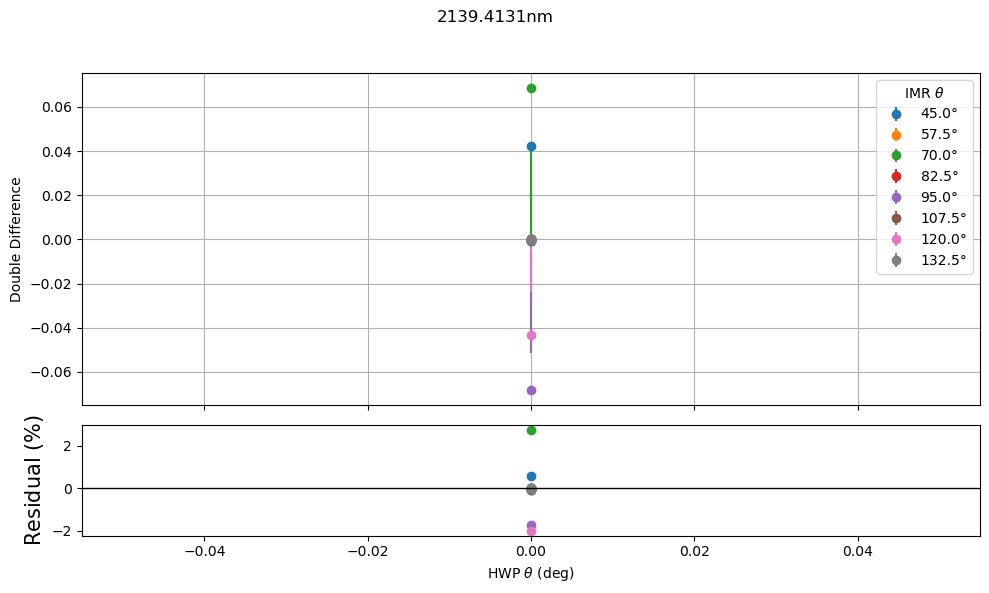

Updated Mueller Matrix:
[[ 0.18703362  0.14891599  0.02665303  0.1053335 ]
 [-0.16864034 -0.13069561 -0.02735387 -0.10774999]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
144 72
Residuals range: -0.019879530402992396 0.02739321347711121
Error: [0.93318436 0.02214597        nan        nan]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.4979e-01                                    1.46e+01    
       1              2         2.1543e-01      5.34e-01       4.12e-01       8.43e-01    
       2              3         1.6085e-01      5.46e-02       8.96e-01       1.27e-02    
       3              4         1.4660e-01      1.43e-02       7.60e-01       1.09e-02    
       4              5         1.4622e-01      3.82e-04       1.36e-01       5.72e-04    
       5              6         1.4621e-01      4.73e-06       4.15e-02       3.08e-05    
       6       

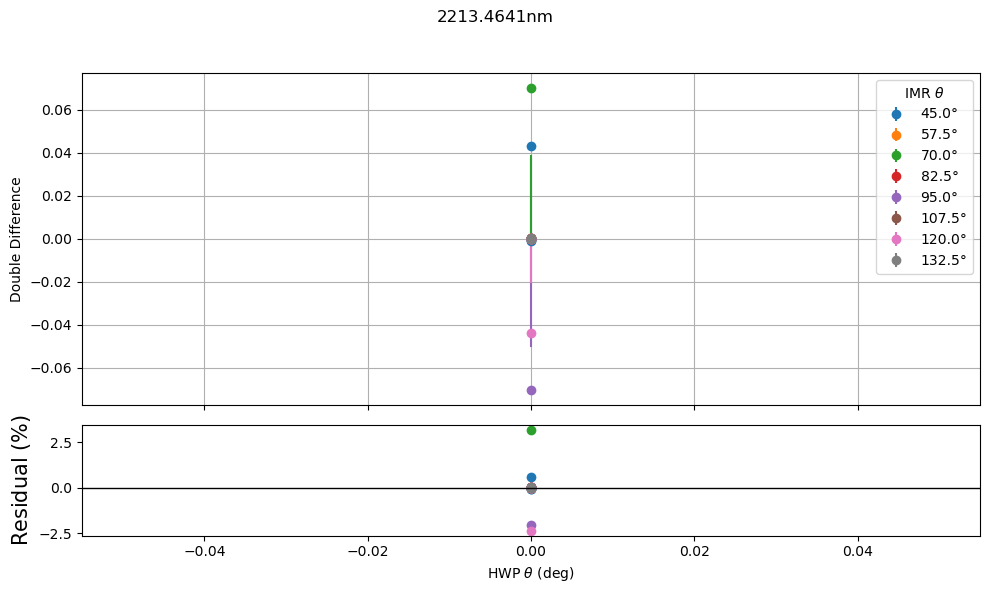

Updated Mueller Matrix:
[[ 0.19095824  0.14524184  0.02935405  0.11414427]
 [-0.16818626 -0.1227258  -0.03030495 -0.11741333]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
144 72
Residuals range: -0.02368383128304405 0.031658010810269366
Error: [1.27097406e+00 2.80984197e-02 2.54760779e+05 2.47534788e+05]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.3043e-01                                    1.47e+01    
       1              2         1.8761e-01      5.43e-01       3.92e-01       8.78e-01    
       2              3         1.3618e-01      5.14e-02       8.89e-01       1.31e-02    
       3              4         1.2158e-01      1.46e-02       8.32e-01       1.29e-02    
       4              5         1.2104e-01      5.48e-04       1.49e-01       7.56e-04    
       5              6         1.2103e-01      7.47e-06       6.05e-02       6.69e-05    

/home/thomasmc/pyPolCal/pyPolCal/fitting.py:160: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(np.diag(cov))


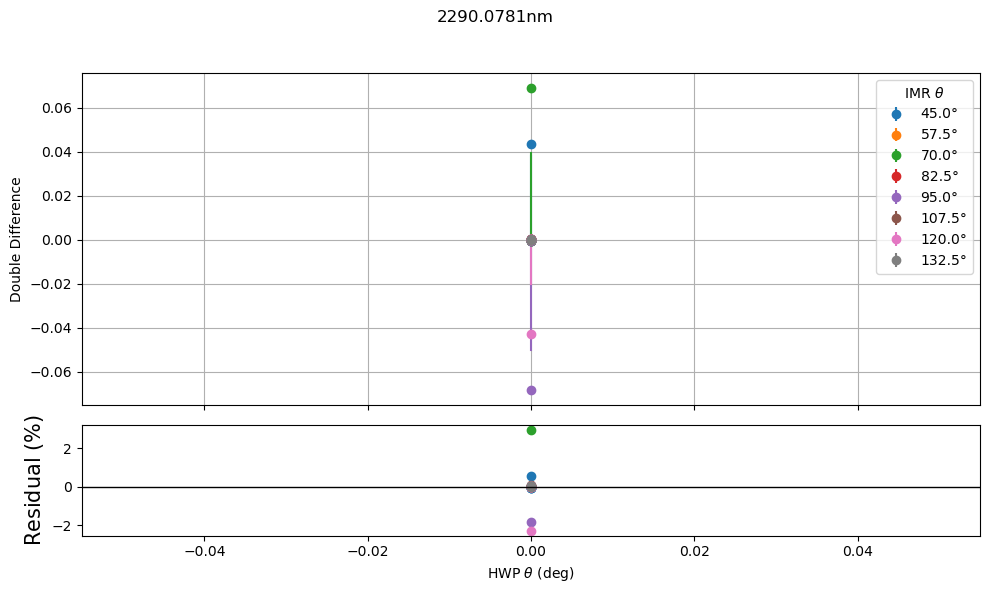

Updated Mueller Matrix:
[[ 0.19181148  0.145538    0.0250567   0.11616657]
 [-0.16921231 -0.12319691 -0.02587896 -0.11947147]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
144 72
Residuals range: -0.02294205763675227 0.029453604056804264
Error: [1.23194747 0.02510305        nan        nan]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6157e+00                                    2.24e+01    
       1              2         3.8523e-01      1.23e+00       4.45e-01       1.99e+00    
       2              3         3.0593e-01      7.93e-02       8.42e-01       2.01e-02    
       3              4         2.8161e-01      2.43e-02       1.38e+00       2.54e-02    
       4              5         2.7964e-01      1.97e-03       7.28e-01       1.13e-02    
       5              6         2.7955e-01      8.41e-05       4.86e-03       1.06e-03    
       6       

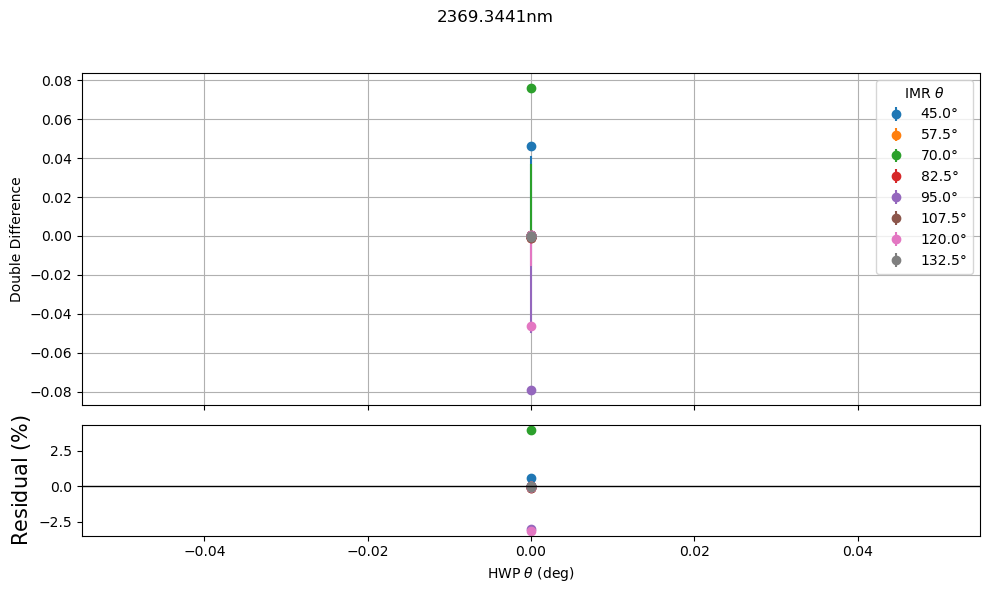

Updated Mueller Matrix:
[[ 0.22000553  0.14213889  0.03436599  0.15099949]
 [-0.18261314 -0.10554728 -0.03624496 -0.15846368]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
144 72
Residuals range: -0.03118840808406185 0.03963050999992476
Error: [2.12459735e+00 4.20093254e-02 7.03285831e+05 6.66956091e+05]


In [1]:
from pyPolCal.instruments import fit_CHARIS_Mueller_matrix_by_bin
errors = []
for bin in range(22):
    jsonpath = f'/home/thomasmc/cubes/jsons/bin{bin}.json'
    csv_path = f'/home/thomasmc/cubes/csvs/bin{bin}.csv'
    error = fit_CHARIS_Mueller_matrix_by_bin(csv_path, bin, jsonpath)
    errors.append(error)

In [2]:
from pyPolCal.csv_tools import model_data
jsondir = '/home/thomasmc/cubes/jsons'
df = model_data(jsondir)
df

,wavelength_bin,hwp_delta_theta,image_rotator_phi,lp_epsilon,wollaston_eta
0,1159.5614,-1.601240,4.511793,1.000000,1.000000
1,1199.6971,-1.888734,4.151830,0.999384,0.999675
2,1241.2219,-1.779847,3.976277,1.000000,1.000000
3,1284.1840,-1.751165,3.769051,1.000000,1.000000
4,1328.6331,-1.650670,3.556861,1.000000,1.000000
5,1374.6208,-1.432538,2.591898,1.000000,1.000000
6,1422.2002,-1.366435,2.336555,1.000000,1.000000
7,1471.4264,-1.297665,2.093062,1.000000,1.000000
8,1522.3565,-1.158268,1.856724,1.000000,1.000000
9,1575.0495,-1.118302,1.653802,1.000000,1.000000


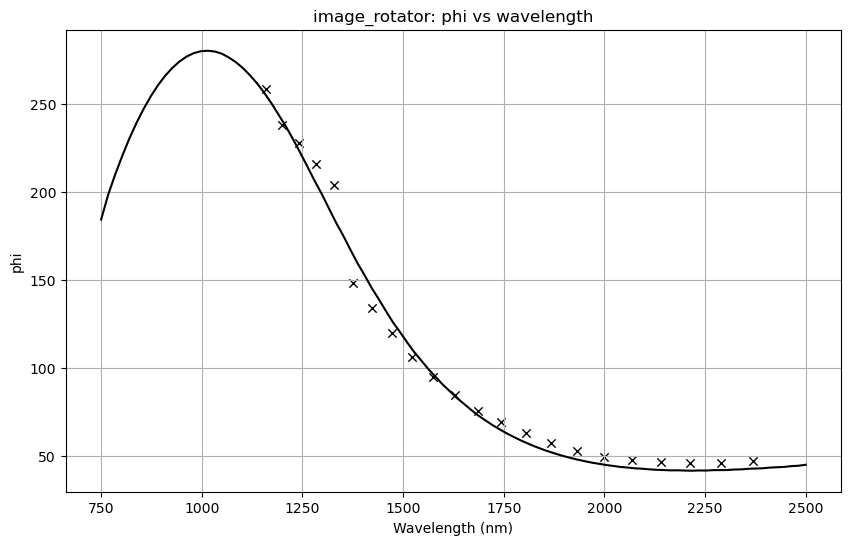

In [6]:
# plot results
from pyPolCal.plotting import plot_config_dict_vs_wavelength
import numpy as np
jsondir = '/home/thomasmc/cubes/jsons'
wavelengths = np.linspace(750,2500,100)
params, fig, ax = plot_config_dict_vs_wavelength('image_rotator','phi',jsondir)
ax.plot(wavelengths, np.rad2deg(IMR_retardance(wavelengths ,259.11814)), label='expected', color='black')
